In [8]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import torchvision
import gpytorch
import torch
from duste.DustAttnCalc import DustAttnCalc
import duste.DustAttnCalc as dd
import lbg_forecast.dust_priors as dp

from uncertainties import ufloat
from uncertainties.umath import log
from uncertainties import unumpy
import scipy as sc

In [2]:
nsamples = 10000
popcosmos_samples = np.load("dust_data/popcosmos_parameters_rmag_lt_25.npy")[:nsamples, :]

In [3]:
dust_samples = popcosmos_samples[:, 8:11]
logsfrratios = popcosmos_samples[:, 2:8]
redshifts = popcosmos_samples[:, -1]
logmasses = popcosmos_samples[:, 0]
recent_sfrs = np.log10(sfh.calculate_recent_sfr(redshifts, 10**logmasses, logsfrratios))

dust2 = dust_samples[:, 0]
dust_index = dust_samples[:, 1]
dust1frac = dust_samples[:, 2]
dust1 = dust1frac*dust2

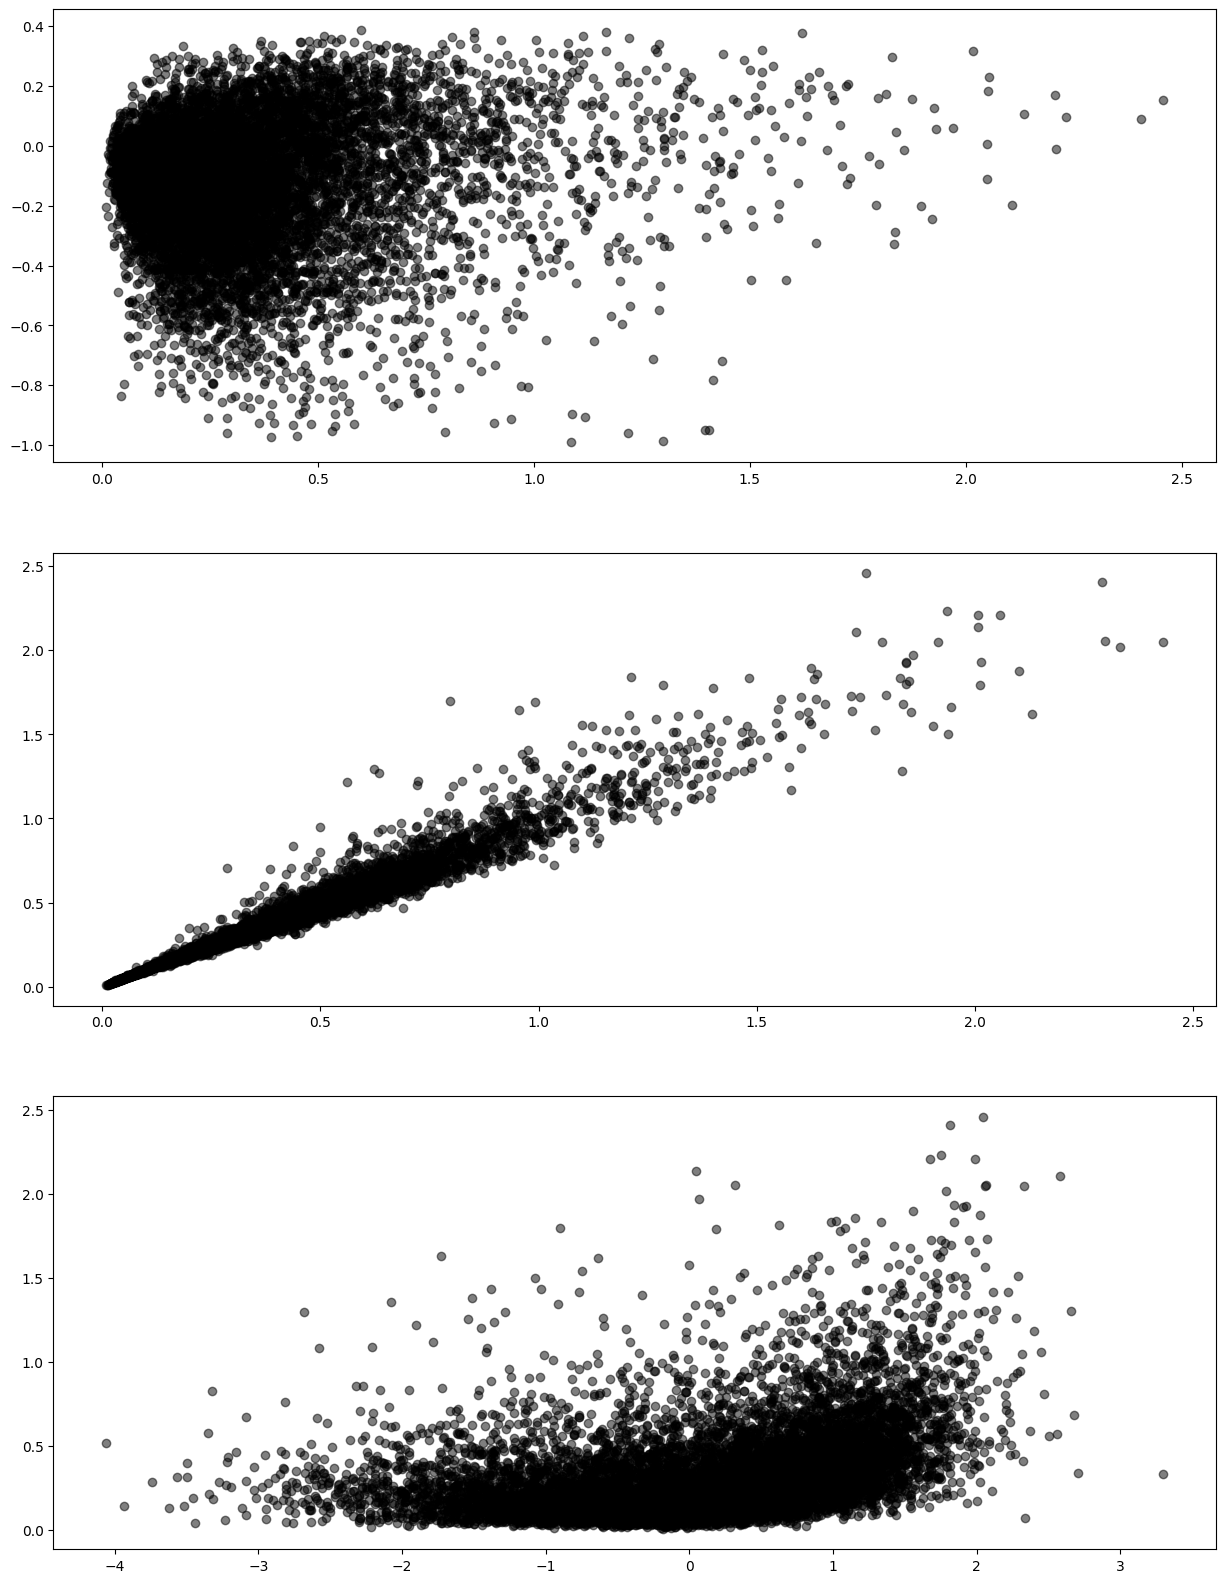

In [4]:
alpha=0.5
f, ax = plt.subplots(3, 1, figsize=(15, 20))
ax[0].scatter(dust2, dust_index, c='k', alpha=0.5)
ax[1].scatter(dust1, dust2, c='k', alpha=0.5)
ax[2].scatter(recent_sfrs, dust2, c='k', alpha=0.5)

In [299]:
def create_gp_model(lengthscale, train_x, train_y):

    class GPModel(gpytorch.models.ExactGP):

        def __init__(self, train_x, train_y, likelihood):
            super(GPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(lengthscale[0], lengthscale[1])))

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood).to(torch.double)

    return model, likelihood

def create_gp_model_obs(lengthscale, train_x, train_y, noise):

    class GPModel(gpytorch.models.ExactGP):

        def __init__(self, train_x, train_y, likelihood):
            super(GPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(lengthscale[0], lengthscale[1])))

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noise)
    model = GPModel(train_x, train_y, likelihood).to(torch.double)

    return model, likelihood

def gp_training_loop(model, likelihood, train_x, train_y, training_iter, lr=1e-4):

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            #i + 1, training_iter, loss.item(),
        print(loss.item())
            #model.likelihood.noise.item()
        #))
        optimizer.step()

    return model, likelihood

def gp_evaluate_model(model, likelihood, test_x):
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()
    f_preds = model(test_x.to(torch.double))

    return f_preds

def gp_plot_confidence(f_preds, test_x, train_x, train_y, labelx, labely, alpha=0.5):

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(10, 7))

        # Get upper and lower confidence bounds
        lower, upper = f_preds.confidence_region()
        # Plot training data as black stars
        ax.scatter(train_x.numpy(), train_y.numpy(), c='k', alpha=alpha)
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), f_preds.mean, 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
        #ax.legend(['Observed Data', 'Mean', 'Confidence'])

        ax.set_xlabel(labelx)
        ax.set_ylabel(labely)


def gp_plot_confidence_obs(f_preds, test_x, train_x, train_y, train_yerrs, labelx, labely, alpha=0.5):

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(10, 7))

        # Get upper and lower confidence bounds
        lower, upper = f_preds.confidence_region()
        # Plot training data as black stars
        ax.errorbar(train_x.numpy(), train_y.numpy(), train_yerrs.numpy(), fmt='ko', capsize=2)
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), f_preds.mean, 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
        #ax.legend(['Observed Data', 'Mean', 'Confidence'])

        ax.set_xlabel(labelx)
        ax.set_ylabel(labely)

def binned_weighted_mean_std(x, y, yerr, bins):

    bin_midpoints = (bins[:-1]+bins[1:])/2
    nbins = len(bins)-1
    bin_indexes = np.digitize(x, bins)-1

    weighted_averages = []
    error = []
    non_empty_bins = []
    for bin in range(nbins):

        y_indexes = np.where(bin_indexes == bin)[0]

        if(len(y_indexes)> 0):
            y_in_bin = y[y_indexes]
            yerrs_in_bin = yerr[y_indexes]
            weights_in_bin = (1/yerrs_in_bin)**2
            weighted_average_in_bin = np.average(y_in_bin, weights=weights_in_bin)
            #error_on_wmean = np.sqrt(1/np.sum(weights_in_bin))
            std_in_bin = np.std(y_in_bin)
            avg_err_in_bin = np.mean(yerrs_in_bin)
            weighted_averages.append(weighted_average_in_bin)
            #set error floor
            if(std_in_bin<avg_err_in_bin):
                error.append(avg_err_in_bin)
            else:
                error.append(std_in_bin)
            non_empty_bins.append(bin_midpoints[bin])

    return np.array(non_empty_bins), np.array(weighted_averages), np.array(error)

3.4390312940090473
3.2884925476475706
3.1345474791525914
2.977615535039961
2.818218361738774
2.6569116937920363
2.494311709734761
2.3310833740622825
2.167936465058019
2.0056184679568174
1.8449067302647115
1.6865995510467764
1.5315063929884984
1.380437193430509
1.2341910058185706
1.093544238978803
0.9592385240247164
0.8319686893812704
0.7123711308119954
0.6010123338706406
0.49837787021313124
0.4048618965123889
0.32075704579077036
0.24624477713932055
0.18138612068231863
0.12611270311703882
0.08021838330037169
0.04335200257238799
0.015012390846425359
-0.005452770416918267
-0.01884198571981764
-0.02608623773224097
-0.028224123130726288
-0.02636780762112367
-0.022756093883627825
-0.01897321189902205
-0.015478801842610397
-0.012643932927717748
-0.010722421380115617
-0.009838539342428981
-0.00999184147093793
-0.011076817647963895
-0.012911863083782288
-0.015272045169357176
-0.017920368820498793
-0.020633760907663695
-0.02322207899655578
-0.025539281286146166
-0.027487794622784445
-0.029017110

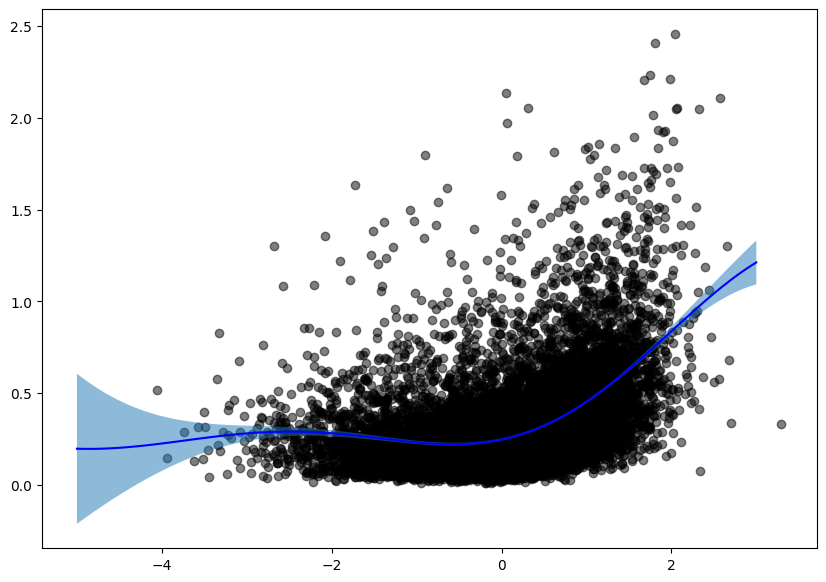

In [6]:
train_sfrs = torch.from_numpy(recent_sfrs)
train_dust2 = torch.from_numpy(dust2)
test_sfrs = torch.linspace(-5, 3, 100)
model, likelihood = create_gp_model([3.0, 15.0], train_sfrs, train_dust2)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_sfrs, train_dust2, training_iter=100, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_sfrs)
gp_plot_confidence(f_preds, test_sfrs, train_sfrs, train_dust2, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

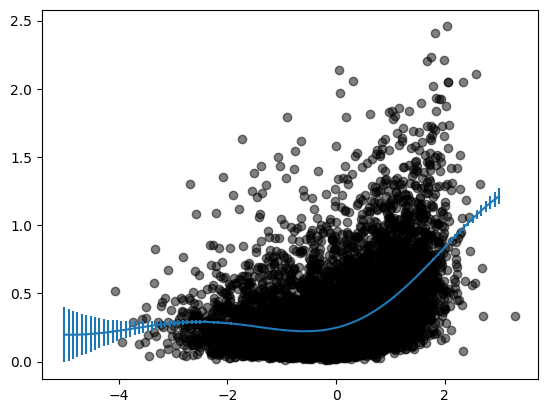

In [7]:
with torch.no_grad():
    #arr = unumpy.uarray(f_preds.mean.numpy(), f_preds.stddev.numpy())
    #arr = unumpy.exp(arr)
    #means = unumpy.nominal_values(arr)
    #stds = unumpy.std_devs(arr)
    means = f_preds.mean.numpy()
    stds = f_preds.stddev.numpy()

plt.errorbar(test_sfrs, means, stds)
plt.scatter(train_sfrs.numpy(), train_dust2.numpy(), c='k', alpha=alpha)

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


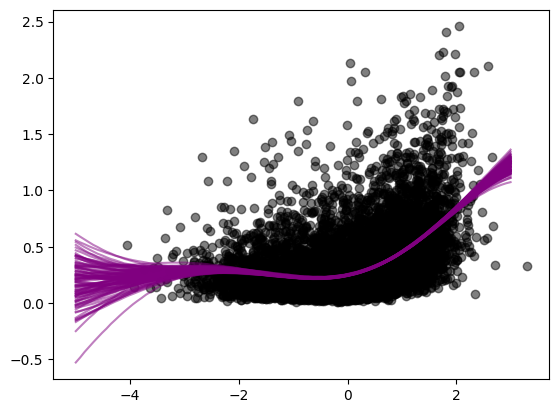

In [8]:
with torch.no_grad():
    for i in range(100):
        plt.plot(test_sfrs, f_preds.sample().numpy(), c='purple', alpha=0.5)

plt.scatter(train_sfrs.numpy(), train_dust2.numpy(), c='k', alpha=alpha)

1.6225599746643777
1.5227911180914786
1.4220861508777285
1.3209077422077269
1.2197648103267693
1.1192084403596914
1.0198259268426555
0.9222330125686956
0.8270640492786755
0.7349595709186693
0.6465512885740662
0.5624444520169822
0.4831978739610653
0.4093025137814146
0.3411588441151542
0.27905471702432405
0.223145080011534
0.17343605929956032
0.12977612712853853
0.0918573588604023
0.059229290989545214
0.02993539486525412
0.0023942608092723016
-0.02319644194203568
-0.04664304606267299
-0.06776298876689482
-0.08639302682952087
-0.1023993304387833
-0.1156891638557455
-0.12622370834609767
-0.13403137242156857
-0.13921969111426727
-0.14198401948023467
-0.14261025773649938
-0.14146936480711786
-0.13900144256829639
-0.13568918811448724
-0.13202269220779084
-0.12845983786844348
-0.12538844957790654
-0.12309643828952223
-0.12175499327885511
-0.12141677835665553
-0.12202809685818004
-0.12345178251571444
-0.1254954517534686
-0.1279407645104847
-0.1305698397960595
-0.13318575027094567
-0.13562674337

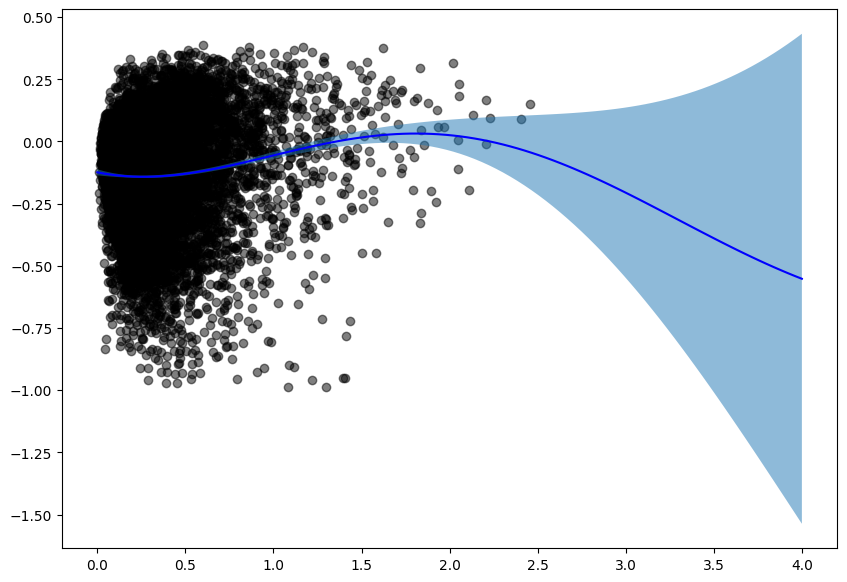

In [9]:
train_dust2 = torch.from_numpy(dust2)
train_dust_index = torch.from_numpy(dust_index)
test_dust2 = torch.linspace(0, 4, 100)
model, likelihood = create_gp_model([2.0, 6.0], train_dust2, train_dust_index)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust_index, training_iter=100, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence(f_preds, test_dust2, train_dust2, train_dust_index, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

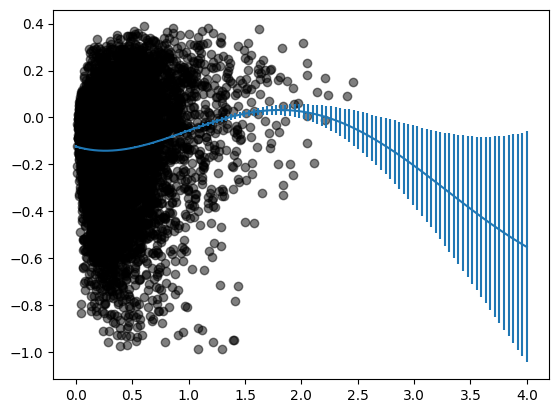

In [10]:
with torch.no_grad():
    means = f_preds.mean.numpy()
    stds = f_preds.stddev.numpy()

plt.errorbar(test_dust2, means, stds)
plt.scatter(train_dust2.numpy(), train_dust_index.numpy(), c='k', alpha=alpha)

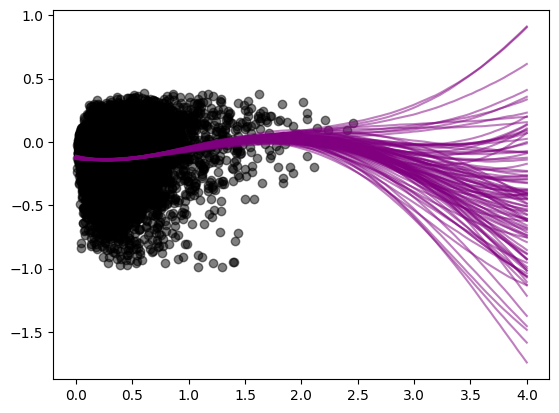

In [11]:
with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.5)

plt.scatter(train_dust2.numpy(), train_dust_index.numpy(), c='k', alpha=alpha)

1.5934132041160345
1.4914055888741518
1.3882313037966136
1.2843256576981599
1.1801663856064526
1.076269333611453
0.9731821485286558
0.8714760791206865
0.7717354796376354
0.6745444192116347
0.5804714667311698
0.49005146668412153
0.4037652954583069
0.3220183367937593
0.24511694787612556
0.1732462118468281
0.10644934742076546
0.04461162197295988
-0.012548368679222962
-0.06547683422635057
-0.11476990559282278
-0.16253612195160524
-0.21051206910109954
-0.25865424018442457
-0.3069173095965748
-0.35525472156152044
-0.4036174773482027
-0.4519568883368319
-0.5002197351040684
-0.5483523504711721
-0.5962971528296652
-0.643996360129733
-0.6913852232672093
-0.7383982076995192
-0.784964756862517
-0.8310099591272015
-0.8764557197776287
-0.9212182145699016
-0.9652069846633787
-1.0083288918922109
-1.0504837263734166
-1.0915665866097375
-1.131466284242206
-1.1700683216275856
-1.2072540728052603
-1.2429006696032352
-1.2768837873120455
-1.30907926824743
-1.3393666814697567
-1.367626560438509
-1.3937516125

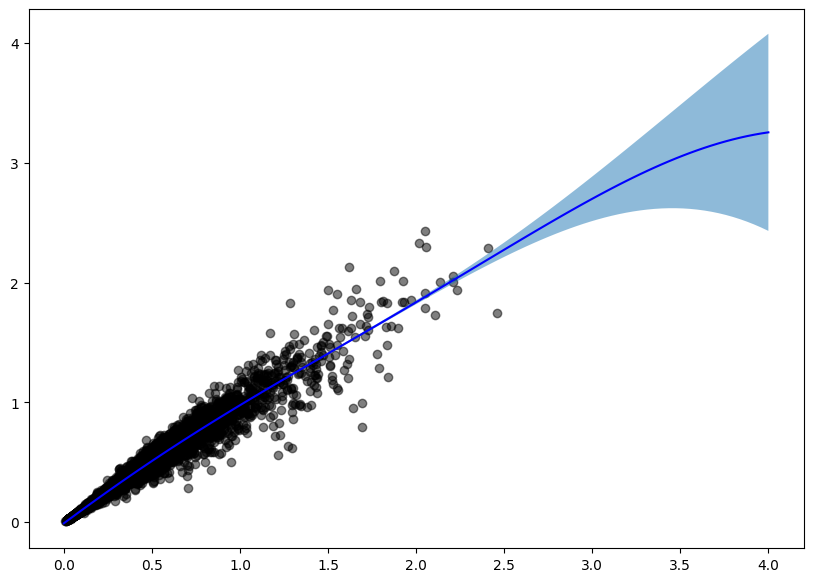

In [12]:
train_dust2 = torch.from_numpy(dust2)
train_dust1 = torch.from_numpy(dust1)
test_dust2 = torch.linspace(0, 4, 100)
model, likelihood = create_gp_model([2.0, 6.0], train_dust2, train_dust1)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust1, training_iter=100, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence(f_preds, test_dust2, train_dust2, train_dust1, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20_HB.dat
Measured grid length from file: 20
d1 values: [0.09265918 0.16517801 0.24159316 0.32006199 0.40667442 0.49387057
 0.56470696 0.65907142 0.71992062 0.81579054 0.94977534 1.03165817
 1.11838698 1.22568968 1.34673601 1.47253277 1.5772873  1.68639503
 1.81996902 1.93449115 2.04689248 2.12317791 2.16850967 2.17415515
 2.18068492 2.1810712  2.1810712  2.1810712  2.1810712  2.1810712
 2.1810712  2.1810712  2.1810712  2.1810712  2.1810712  2.1810712
 2.1810712  2.1810712  2.1810712  2.1810712  2.1810712  2.1810712
 2.1810712  2.1810712  2.1810712  2.1810712  2.1810712  2.1810712
 2.1810712  2.1810712 ]
d1e values: [0.05162146 0.06596811 0.05620016 0.06740064 0.06729194 0.05610234
 0.0686489

<ErrorbarContainer object of 3 artists>

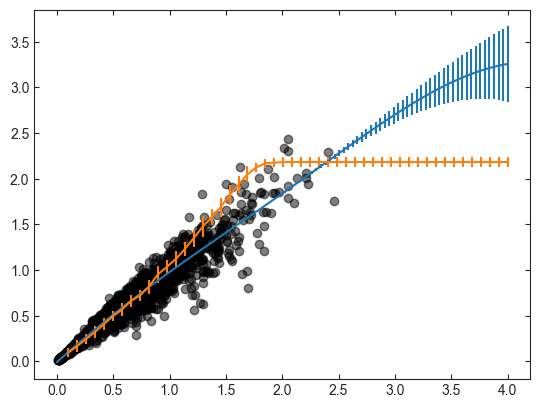

In [22]:
with torch.no_grad():
    means = f_preds.mean.numpy()
    stds = f_preds.stddev.numpy()

plt.errorbar(test_dust2, means, stds)
plt.scatter(train_dust2.numpy(), train_dust1.numpy(), c='k', alpha=alpha)

d2 = np.linspace(0.1,4.0,50)
dobj = DustAttnCalc()
d1sim, _ = dobj.get_d1(d2)
d1, d1e = np.average(d1sim, axis=0), np.std(d1sim, axis=0)
print("d1 values:", d1)
print("d1e values:", d1e)

plt.errorbar(d2, d1, d1e)

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/operators/_linear_operator.py:2163: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.. Using symeig method.
  warnings.warn(


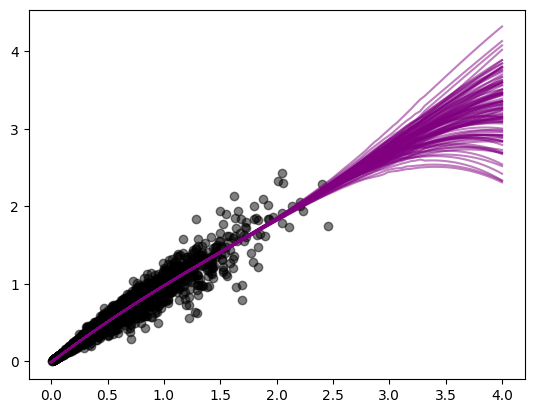

In [14]:
with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.5)

plt.scatter(train_dust2.numpy(), train_dust1.numpy(), c='k', alpha=alpha)

In [621]:
ngal = 20000
#sfrsamples = np.random.uniform(-8, 2, ngal)
logM = np.random.uniform(8.74,11.30,ngal)
sfr = np.random.uniform(-3,3,ngal)
logZ = np.random.uniform(-1.70,0.18,ngal)
dobj = DustAttnCalc(sfr=sfr, logM=logM, logZ=logZ, bv=True, eff=False)
dac, dac1, n, tau, tau1, ne, taue, tau1e = dobj.calcDust(max_num_plot=0)

Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_small.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_HB.dat
Measured grid length from file: 5
Mins: {'logM': 8.74, 'sfr': -2.06, 'logZ': -1.7, 'z': 0.51, 'i': 0.09, 'd1': 0.01, 'd2': 0.01, 'de': 0.01}
Maxs: {'logM': 11.3, 'sfr': 2.11, 'logZ': 0.18, 'z': 2.83, 'i': 0.97, 'd1': 2.23, 'd2': 1.95, 'de': 2.19}
Marginalizing over z
Marginalizing over i
Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20_HB.dat
M

mean: 0.05336925655218075 std: 0.006154912916937849
[-2.75 -2.25 -1.75 -1.25 -0.75 -0.25  0.25  0.75  1.25  1.75  2.25] [0.6014264  0.58345333 0.57060361 0.55753651 0.5533179  0.53624957
 0.63369585 0.76443745 0.88967948 1.03319137 1.17047225] [0.11194514 0.11824977 0.1305046  0.13932326 0.15583237 0.17251497
 0.23702782 0.21546871 0.16729805 0.14793411 0.16708235]


<ErrorbarContainer object of 3 artists>

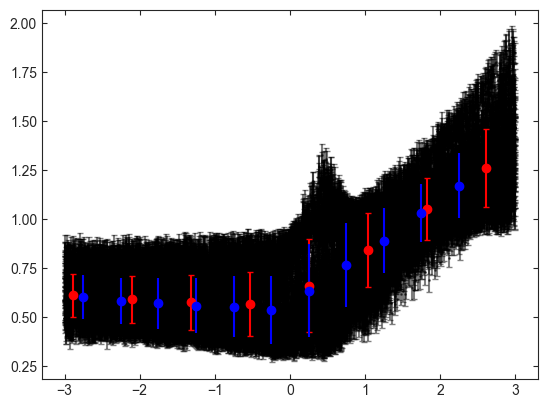

In [622]:
print("mean:", np.mean(taue), "std:", np.std(taue))
plt.errorbar(sfr, tau, taue, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)
bin_means_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(sfr, tau, 'mean', np.linspace(-8, 3, 15))
bin_std_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(sfr, tau, 'std', np.linspace(-8, 3, 15))
bin_width_de = (bin_edges_de[1] - bin_edges_de[0])
bin_centers_de = bin_edges_de[1:] - bin_width_de/2

plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
sfr_bins = np.arange(-3, 3, 0.5)
x, y, yerr = binned_weighted_mean_std(sfr, tau, taue, sfr_bins)
print(x, y, yerr)
plt.errorbar(x, y, yerr, fmt='bo')

<ErrorbarContainer object of 3 artists>

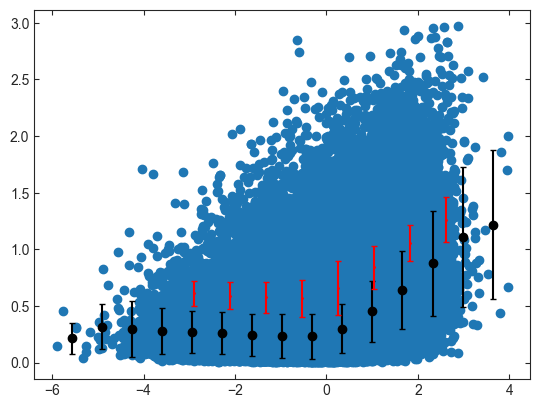

In [624]:
#sfrsamples = np.linspace(-8, 2, 20)
#dobj = DustAttnCalc(sfr=sfrsamples, bv=True, eff=False)
#dac, dac1, n, tau, tau1, ne, taue, tau1e = dobj.calcDust(max_num_plot=0)

nsamples = 500000
popcosmos_samples = np.load("dust_data/popcosmos_parameters_rmag_lt_25.npy")[:nsamples, :]

dust_samples = popcosmos_samples[:, 8:11]
logsfrratios = popcosmos_samples[:, 2:8]
redshifts = popcosmos_samples[:, -1]
logmasses = popcosmos_samples[:, 0]
recent_sfrs = np.log10(sfh.calculate_recent_sfr(redshifts, 10**logmasses, logsfrratios))

dust2 = dust_samples[:, 0]
dust_index = dust_samples[:, 1]
dust1frac = dust_samples[:, 2]
dust1 = dust1frac*dust2

plt.scatter(recent_sfrs, dust2)

bin_means, bin_edges, binnumber = sc.stats.binned_statistic(recent_sfrs, dust2,'mean', 15)
bin_std, bin_edges, binnumber = sc.stats.binned_statistic(recent_sfrs, dust2,'std', 15)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

tensor([-5.5679, -4.9106, -4.2534, -3.5961, -2.9389, -2.2817, -1.6244, -0.9672,
        -0.3099,  0.3473,  1.0046,  1.6618,  2.3190,  2.9763,  3.6335, -2.8929,
        -2.1071, -1.3214, -0.5357,  0.2500,  1.0357,  1.8214,  2.6071],
       dtype=torch.float64) tensor([0.2137, 0.3149, 0.2967, 0.2761, 0.2670, 0.2581, 0.2462, 0.2343, 0.2301,
        0.2995, 0.4522, 0.6405, 0.8761, 1.1074, 1.2185, 0.6098, 0.5897, 0.5755,
        0.5675, 0.6598, 0.8405, 1.0528, 1.2611], dtype=torch.float64) tensor([0.1363, 0.1995, 0.2458, 0.2019, 0.1860, 0.1857, 0.1848, 0.1912, 0.1973,
        0.2192, 0.2672, 0.3478, 0.4643, 0.6180, 0.6576, 0.1119, 0.1214, 0.1401,
        0.1623, 0.2375, 0.1893, 0.1596, 0.1981], dtype=torch.float64)
2378.0634002557267
2304.9205347149473
2229.394613276943
2151.6504114992085
2071.8790675238483
1990.297693851917
1907.1484377862319
1822.6969585491072
1737.2303215581105
1651.0543389616043
1564.4904054034391
1477.8718955128868
1391.5402074900105
1305.8405523510762
1221.11759716719

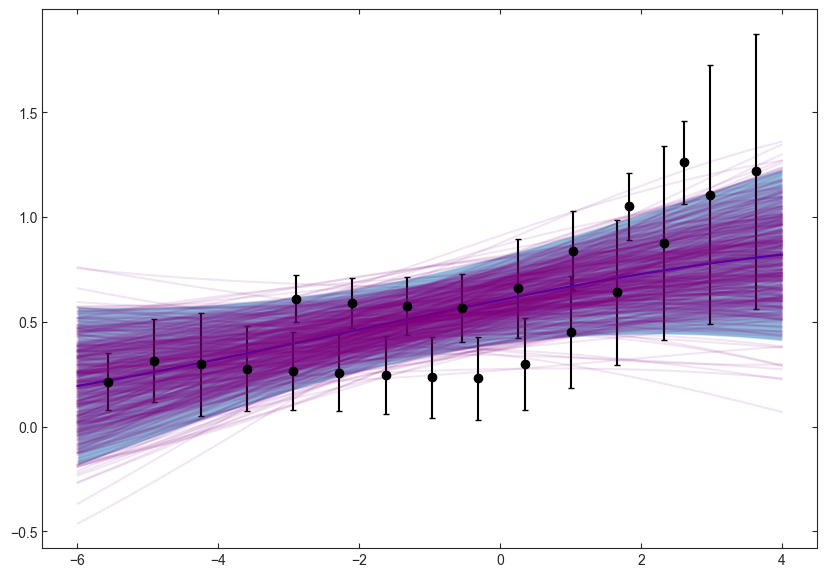

In [647]:
train_sfrs = torch.from_numpy(np.hstack((bin_centers, bin_centers_de)))
train_dust2 = torch.from_numpy(np.hstack((bin_means, bin_means_de)))
train_dust2_errs = torch.from_numpy(np.hstack((bin_std, bin_std_de)))

train_sfrs = torch.from_numpy(np.delete(train_sfrs.numpy(), np.where(np.isnan(train_dust2)==1)[0]))
train_dust2_errs = torch.from_numpy(np.delete(train_dust2_errs.numpy(), np.where(np.isnan(train_dust2)==1)[0]))
train_dust2 = torch.from_numpy(np.delete(train_dust2.numpy(), np.where(np.isnan(train_dust2)==1)[0]))

print(train_sfrs, train_dust2, train_dust2_errs)

test_sfrs = torch.linspace(-6, 4, 100)

model, likelihood = create_gp_model_obs([4.0, 10.0], train_sfrs, train_dust2, train_dust2_errs)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_sfrs, train_dust2, training_iter=20000, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_sfrs)
gp_plot_confidence_obs(f_preds, test_sfrs, train_sfrs, train_dust2, train_dust2_errs, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_sfrs, f_preds.sample().numpy(), c='purple', alpha=0.1)

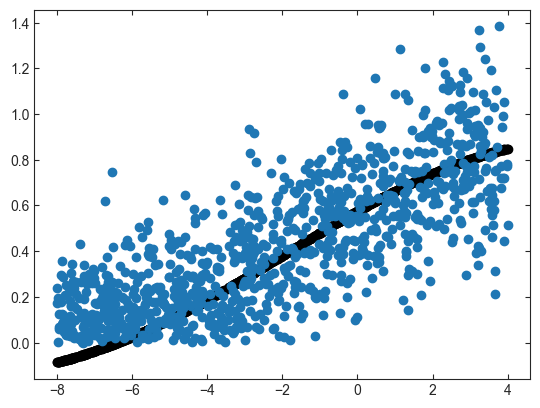

In [680]:
test_sfrs = torch.from_numpy(np.random.uniform(-8, 4, 1000))
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_sfrs)
mean_dust2 = f_preds.sample().numpy()
scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_sfrs, mean_dust2, c='k')
plt.scatter(test_sfrs, dp.truncated_normal(mean_dust2, scatter, 0.0, 4.0, len(test_sfrs)))

mean: 0.0429736279853245 std: 0.0045145979621704045
[0.375 0.625 0.875 1.125 1.375 1.625 1.875] [-0.09317705 -0.12270392 -0.16527376 -0.16199263 -0.17049409 -0.12919215
 -0.08921399] [0.07637538 0.08968656 0.09968638 0.11024536 0.08698787 0.05223131
 0.04282876]


<ErrorbarContainer object of 3 artists>

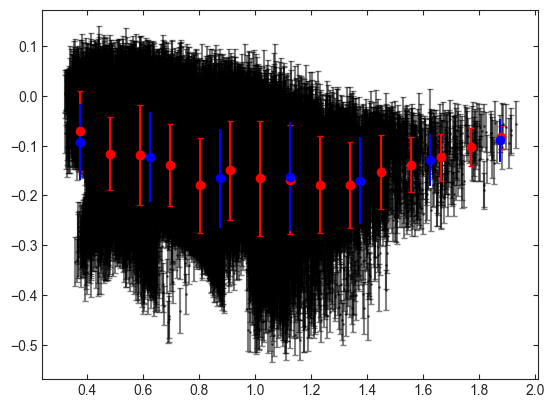

In [681]:
print("mean:", np.mean(ne), "std:", np.std(ne))

bin_means_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(tau, n, 'mean', 15)
bin_std_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(tau, n, 'std', 15)
bin_width_de = (bin_edges_de[1] - bin_edges_de[0])
bin_centers_de = bin_edges_de[1:] - bin_width_de/2

plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(tau, n, ne, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)

tau_bins = np.arange(0.25, 4.25, 0.25)
x, y, yerr = binned_weighted_mean_std(tau, n, ne, tau_bins)
print(x, y, yerr)
plt.errorbar(x, y, yerr, fmt='bo')

<ErrorbarContainer object of 3 artists>

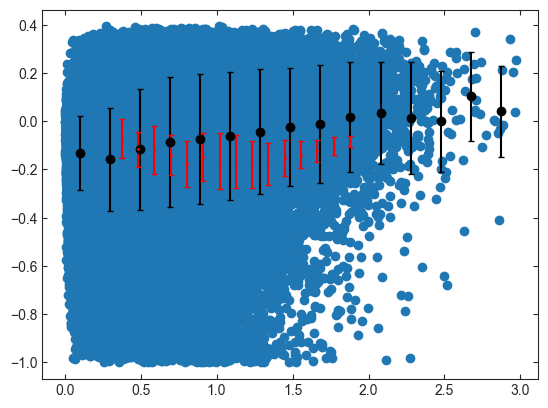

In [682]:
plt.scatter(dust2, dust_index)

bin_means, bin_edges, binnumber = sc.stats.binned_statistic(dust2, dust_index,'mean', 15)
bin_std, bin_edges, binnumber = sc.stats.binned_statistic(dust2, dust_index,'std', 15)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

284.83350952238726
262.9315469260997
240.90175488070344
218.88652045660683
197.0415147015537
175.5342613508927
154.54207243985758
134.24927725949834
114.8436885019688
96.51226927441388
79.43598549898799
63.78385912443435
49.7062892698685
37.32778861347832
26.739396699130925
17.99118389351666
11.085445715046593
5.971386943667288
2.5422622821210163
0.6360001183047881
0.0401947914740277
0.03712451841584232
0.03441835650617017
0.03188069976436222
0.029493905217488618
0.027243746641016045
0.02511858788780971
0.023108778021944228
0.02120620499037525
0.01940396305731619
0.01769610231992842
0.016077437832658737
0.014543402331585886
0.01308993109615968
0.011713370697944248
0.010410405670633945
0.009177998772735204
0.008013341696255708
0.006913813933671535
0.005876948142620379
0.004900400806550461
0.0039819273244094365
0.0031193609049536904
0.002310594814132368
0.0015535676439202136
0.000846251350461591
0.00018664185805371917
-0.0004272479490539253
-0.0009973930166299846
-0.0015257588652197137
-

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


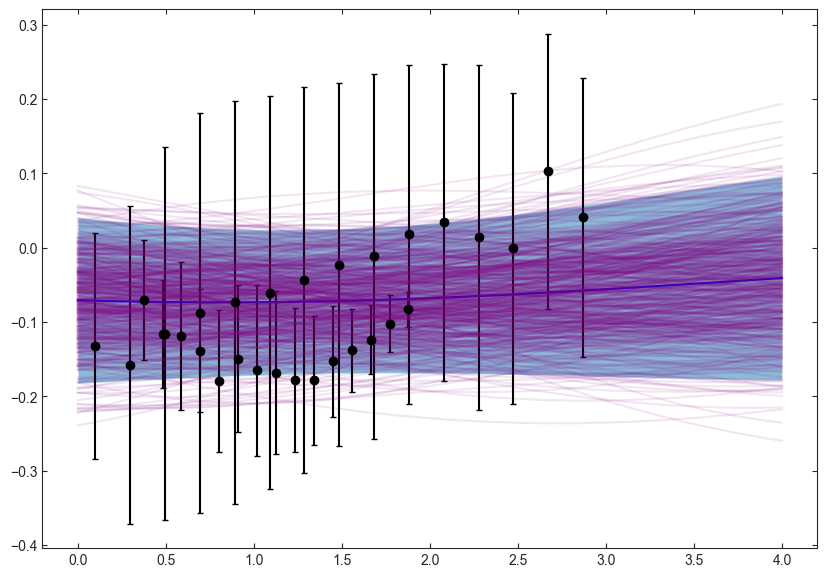

In [683]:
train_dust2 = torch.from_numpy(np.hstack((bin_centers, bin_centers_de)))
train_dust_index = torch.from_numpy(np.hstack((bin_means, bin_means_de)))
train_dust_index_errs = torch.from_numpy(np.hstack((bin_std, bin_std_de)))
test_dust2 = torch.linspace(0, 4, 100)

model, likelihood = create_gp_model_obs([2.0, 6.0], train_dust2, train_dust_index, train_dust_index_errs)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust_index, training_iter=10000, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust_index, train_dust_index_errs, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

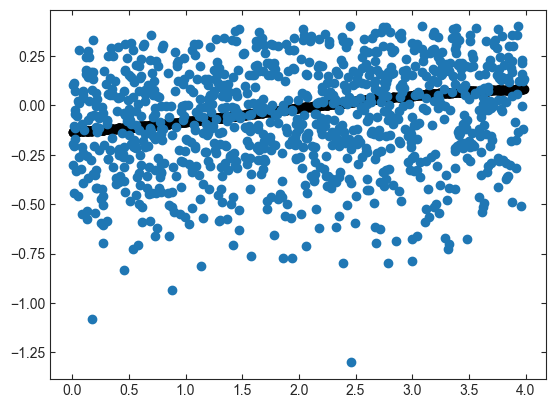

In [724]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_tau)
mean_dust_index = f_preds.sample().numpy()
scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_tau, mean_dust_index, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust_index, scatter, -2.2, 0.4, len(test_tau)))

mean: 0.06214571174982715 std: 0.012569489139135295
[0.375 0.625 0.875 1.125 1.375 1.625 1.875] [0.43143878 0.61815963 0.86519704 1.17231056 1.53450908 1.94005176
 2.15144629] [0.05208931 0.07880721 0.08854677 0.09630711 0.10077818 0.09845684
 0.03081881]


<ErrorbarContainer object of 3 artists>

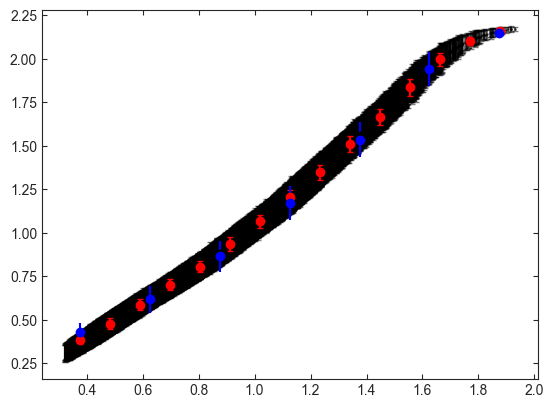

In [728]:
plt.errorbar(tau, tau1, tau1e, fmt='ko', ms=1, capsize=2, alpha=0.5)

print("mean:", np.mean(tau1e), "std:", np.std(tau1e))

bin_means_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(tau, tau1, 'mean', 15)
bin_std_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(tau, tau1, 'std', 15)
bin_width_de = (bin_edges_de[1] - bin_edges_de[0])
bin_centers_de = bin_edges_de[1:] - bin_width_de/2


plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)

tau_bins = np.arange(0.25, 4.25, 0.25)
x, y, yerr = binned_weighted_mean_std(tau, tau1, tau1e, tau_bins)
print(x, y, yerr)
plt.errorbar(x, y, yerr, fmt='bo')


<ErrorbarContainer object of 3 artists>

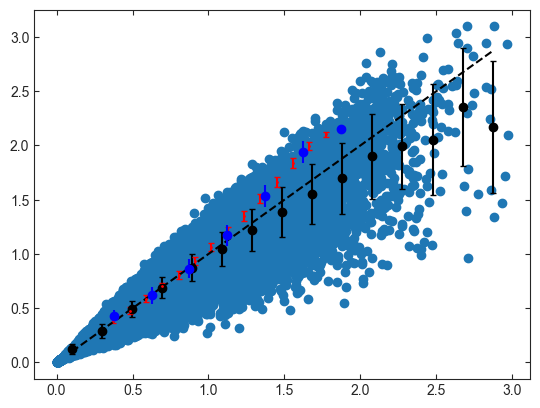

In [729]:
plt.scatter(dust2, dust1)

bin_means, bin_edges, binnumber = sc.stats.binned_statistic(dust2, dust1,'mean', 15)
bin_std, bin_edges, binnumber = sc.stats.binned_statistic(dust2, dust1,'std', 15)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)
plt.plot(bin_centers, bin_centers, c='k', ls='--')
plt.errorbar(x, y, yerr, fmt='bo')

2485.8698476228924
2409.4112744828462
2330.461737371254
2249.19315200465
2165.8051014798166
2080.5244084499022
1993.6041325327233
1905.3219647299209
1815.9780152488638
1725.8920195546598
1635.4000149774458
1544.8505631268113
1454.600610150701
1365.011087715864
1276.4423635023913
1189.2496518463945
1103.7784931614929
1020.3604048202935
939.3087964241531
860.9152295215935
785.4460869776394
713.1397016051333
644.2039784654162
578.8145312703961
517.1133410938245
459.20793535426236
405.1710767480239
355.0409452839667
308.821791475975
266.4850346917646
227.97077723596905
193.18970159564378
162.0253151050883
134.33650290326793
109.9603463875841
88.71516046147953
70.40369889600309
54.81647334169188
41.7351282733804
30.93581179961531
22.192481188620828
15.280082476196577
9.977545863763925
6.070542905623231
3.353957703737396
1.6340323116318052
0.7301559957646238
0.47589579756291567
0.47591899373086954
0.4758697959026257
0.47576038468842524
0.4756013822788924
0.475402002404333
0.475170197609823
0

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


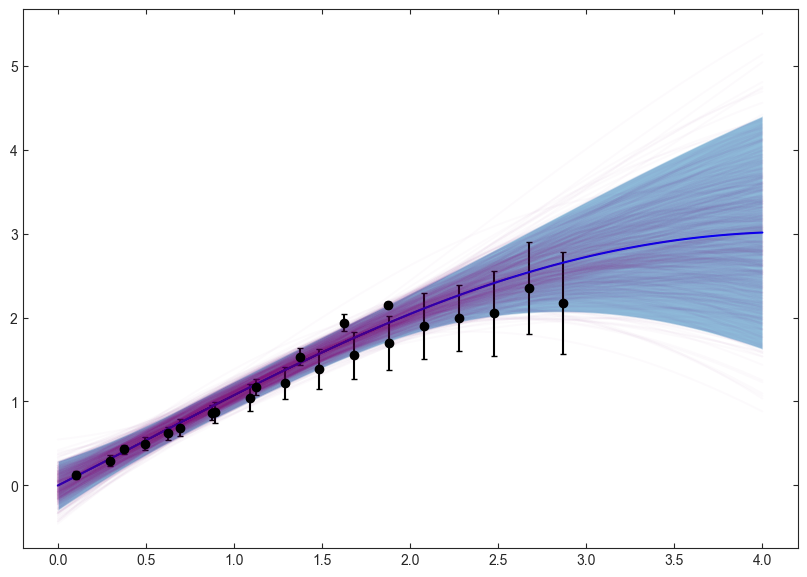

In [759]:
train_dust2 = torch.from_numpy(np.hstack((bin_centers, x)))
train_dust1 = torch.from_numpy(np.hstack((bin_means, y)))
train_dust1_errs = torch.from_numpy(np.hstack((bin_std, yerr)))
test_dust2 = torch.linspace(0, 4, 100)

model, likelihood = create_gp_model_obs([4.0, 10.0], train_dust2, train_dust1, train_dust1_errs)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust1, training_iter=10000, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1, train_dust1_errs, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.02)

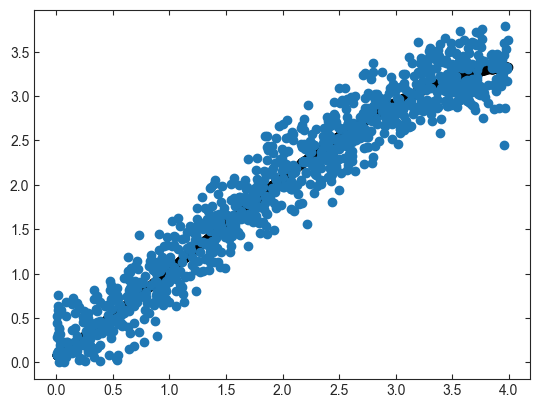

In [783]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_tau)
mean_dust1 = f_preds.sample().numpy()
scatter = np.random.uniform(0.05, 0.3)
plt.scatter(test_tau, mean_dust1, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust1, scatter, 0.0, 4.0, len(test_tau)))